In [2]:
import json
import networkx as nx
import pandas as pd

In [ ]:
# Load JSONL data
data = []
with open('data/50kwithPaths.json', 'r', encoding='utf-8') as f:
    for line in f:
        record = json.loads(line)
        nodes = record['path']['nodes']
        rel = record['path']['relationships'][0]  # one relationship per path

        user = next(node for node in nodes if 'User' in node['labels'])
        app = next(node for node in nodes if 'App' in node['labels'])

        data.append({
            'user_id': user['properties'].get('ident'),
            'app_id': app['properties'].get('ident'),
            'app_name': app['properties'].get('name'),
            'playtime': rel['properties'].get('playtime', 0)
        })

df = pd.DataFrame(data)

In [2]:
agg_df = df.groupby(['app_id', 'app_name']).agg(
    owners=('user_id', 'nunique'),
    avg_playtime=('playtime', 'mean'),
    median_playtime=('playtime', 'median'),
    zero_playtime=('playtime', lambda x: (x == 0).sum())
).reset_index()

agg_df['zero_playtime_ratio'] = agg_df['zero_playtime'] / agg_df['owners']
agg_df.head()

,app_id,app_name,owners,avg_playtime,median_playtime,zero_playtime,zero_playtime_ratio
0,1000310,人气动漫大乱斗,1,0.0,0.0,1,1.0
1,1000380,Rogue Reaper,2,0.0,0.0,2,1.0
2,1000510,The Marvellous Machine,2,0.0,0.0,2,1.0
3,1000550,Love Hentai: Endgame,1,0.0,0.0,1,1.0
4,1000830,Gachi Finder 3000,2,0.0,0.0,2,1.0


In [3]:
# Define thresholds
min_owners = 100
max_avg_playtime = 10  # minutes
min_zero_ratio = 0.8   # 80% or more have not played

backlog_df = agg_df[
    (agg_df['owners'] >= min_owners) &
    ((agg_df['avg_playtime'] <= max_avg_playtime) | (agg_df['zero_playtime_ratio'] >= min_zero_ratio))
]
backlog_df

,app_id,app_name,owners,avg_playtime,median_playtime,zero_playtime,zero_playtime_ratio
323,1037200,Offworld Trading Company - Core Game Upgrade,128,0.0,0.0,128,1.0
374,1045980,Stellaris: Ancient Relics Story Pack,133,0.0,0.0,133,1.0
4429,1668560,Age of Empires IV - 4K HDR Video Pack,121,0.0,0.0,121,1.0
8308,226667,Crusader Kings II: Sons of Abraham,123,0.0,0.0,123,1.0
15288,456200,Cities: Skylines - Match Day,165,0.0,0.0,165,1.0
15623,563850,Cities: Skylines - Pearls From the East,128,0.0,0.0,128,1.0
16033,715192,"Cities: Skylines - Carols, Candles and Candy",105,0.0,0.0,105,1.0
16291,799751,BATTLETECH - Shadow Hawk Pack,108,0.0,0.0,108,1.0
16888,911930,BATTLETECH Flashpoint,124,0.0,0.0,124,1.0


In [4]:
edges = pd.read_csv("data/edges_extended.csv")
nodes = pd.read_csv("data/nodes_extended.csv", low_memory = False)

In [14]:
nodes.labels

0         User
1          App
2         User
3          App
4          App
          ... 
126526     App
126527     App
126528     App
126529     App
126530     App
Name: labels, Length: 126531, dtype: object

In [8]:
edges.columns

Index(['id', 'start_node', 'end_node', 'label', 'playtime', 'source', 'target',
       'relation_strength'],
      dtype='object')

In [16]:
users = nodes[nodes['labels'] == 'User']
apps = nodes[nodes['labels'] == 'App']

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
assert len(users) + len(apps) == len(nodes)

<Axes: >

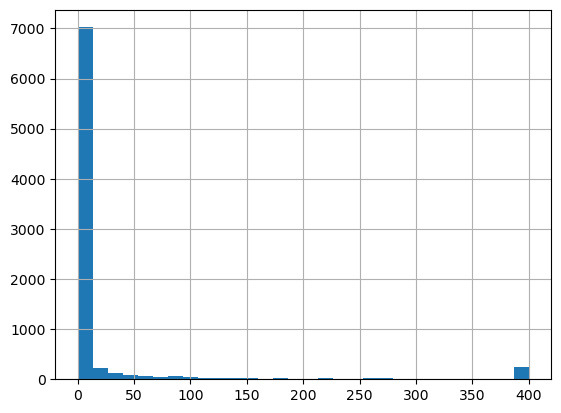

In [36]:
edges.playtime.clip(upper = 400).hist(bins = 30)

In [44]:
zero_playtime = edges[edges['playtime'] == 0]
zero_playtime_count = zero_playtime.groupby('start_node').size().rename('zero_playtime_count')

In [54]:
total_playtime_count = edges.groupby('start_node').size().rename('total_games_owned')


In [56]:
user_game_stats = pd.concat([zero_playtime_count, total_playtime_count], axis=1).fillna(0)
user_game_stats['zero_playtime_ratio'] = user_game_stats['zero_playtime_count'] / user_game_stats['total_games_owned']


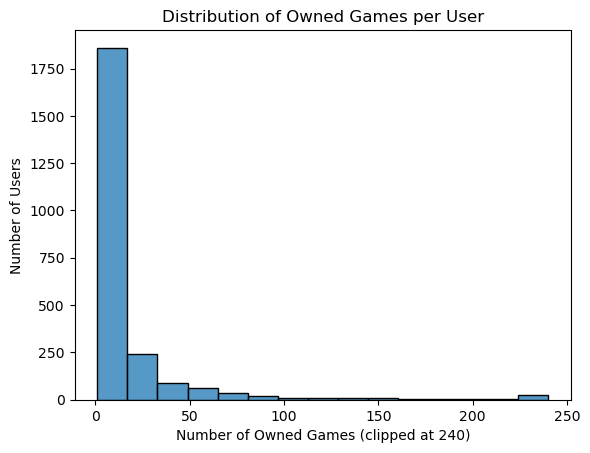

In [107]:
sns.histplot(user_game_stats['total_games_owned'].clip(upper = 240), bins=15, kde=False)
plt.xlabel("Number of Owned Games (clipped at 240)")
plt.ylabel("Number of Users")
plt.title("Distribution of Owned Games per User")
plt.savefig("owned_games_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

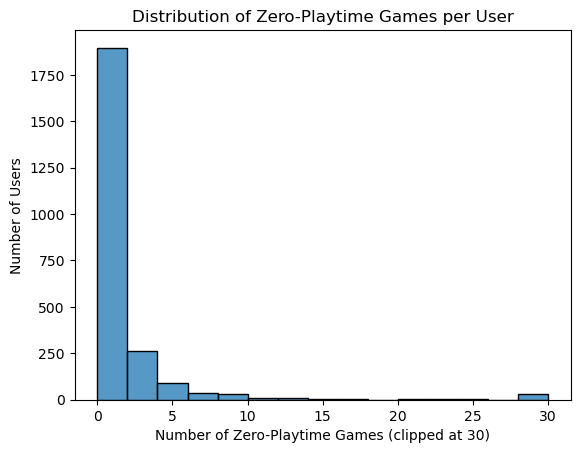

In [101]:
sns.histplot(user_game_stats['zero_playtime_count'].clip(upper = 30), bins=15, kde=False)
plt.xlabel("Number of Zero-Playtime Games (clipped at 30)")
plt.ylabel("Number of Users")
plt.title("Distribution of Zero-Playtime Games per User")
plt.savefig("zero_playtime_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

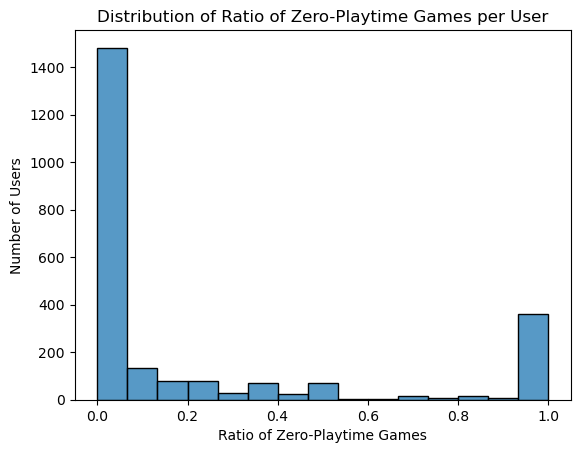

In [85]:
sns.histplot(user_game_stats['zero_playtime_ratio'], bins=15, kde=False)
plt.xlabel("Ratio of Zero-Playtime Games")
plt.ylabel("Number of Users")
plt.title("Distribution of Ratio of Zero-Playtime Games per User")
plt.savefig("zero_playtime_ratio_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

In [129]:
# Define quantile thresholds
lower_q = 0.0
upper_q = 0.95

# Clip zero-playtime counts
clipped_zero = user_game_stats['zero_playtime_count'].clip(
    lower=user_game_stats['zero_playtime_count'].quantile(lower_q),
    upper=user_game_stats['zero_playtime_count'].quantile(upper_q)
)

# Clip total games owned
clipped_total = user_game_stats['total_games_owned'].clip(
    lower=user_game_stats['total_games_owned'].quantile(lower_q),
    upper=user_game_stats['total_games_owned'].quantile(upper_q)
)


In [131]:
mean_zero = clipped_zero.mean()
var_zero = clipped_zero.var()
dispersion_zero = var_zero / mean_zero if mean_zero != 0 else float('inf')

mean_total = clipped_total.mean()
var_total = clipped_total.var()
dispersion_total = var_total / mean_total if mean_total != 0 else float('inf')

print("Clipped Zero-playtime games:")
print(f"  Mean              = {mean_zero:.2f}")
print(f"  Variance          = {var_zero:.2f}")
print(f"  Variance / Mean   = {dispersion_zero:.2f}")

print("\nClipped Total games owned:")
print(f"  Mean              = {mean_total:.2f}")
print(f"  Variance          = {var_total:.2f}")
print(f"  Variance / Mean   = {dispersion_total:.2f}")


Clipped Zero-playtime games:
  Mean              = 1.01
  Variance          = 2.65
  Variance / Mean   = 2.63

Clipped Total games owned:
  Mean              = 12.20
  Variance          = 325.67
  Variance / Mean   = 26.69


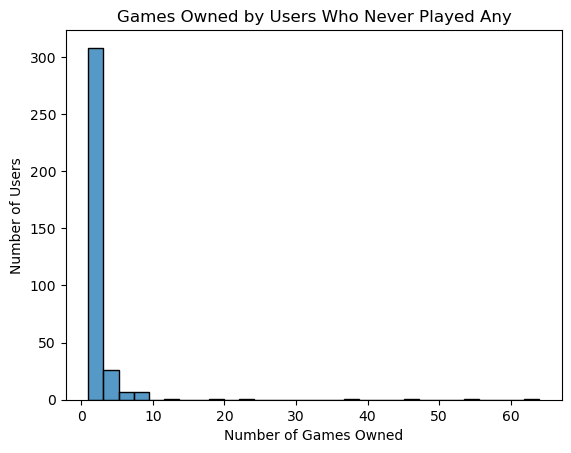

In [133]:
# Subset of users who never played any of their owned games
nonplaying_users = user_game_stats[user_game_stats['zero_playtime_ratio'] == 1]

# Histogram of their total games owned
sns.histplot(nonplaying_users['total_games_owned'], bins=30)
plt.xlabel("Number of Games Owned")
plt.ylabel("Number of Users")
plt.title("Games Owned by Users Who Never Played Any")
plt.show()

In [135]:
owned = nonplaying_users['total_games_owned']
print(f"Count = {len(owned)}")
print(f"Mean  = {owned.mean():.2f}")
print(f"Var   = {owned.var():.2f}")
print(f"Var/Mean = {(owned.var()/owned.mean()):.2f}")


Count = 355
Mean  = 2.40
Var   = 32.31
Var/Mean = 13.48


In [139]:
owned.max()

64